In [45]:
path="fashion_data/"

import gzip
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn

label_file=gzip.open(path + 'train-labels-idx1-ubyte.gz')
y_train= np.frombuffer(label_file.read(), dtype=np.uint8, offset=8)

image_file=gzip.open(path + 'train-images-idx3-ubyte.gz', 'rb')
x_train= np.frombuffer(image_file.read(), dtype=np.uint8, offset=16).reshape(len(y_train), 784)

valid_label_file=gzip.open(path + 't10k-labels-idx1-ubyte.gz')
y_valid= np.frombuffer(valid_label_file.read(), dtype=np.uint8, offset=8)

valid_image_file=gzip.open(path + 't10k-images-idx3-ubyte.gz', 'rb')
x_valid= np.frombuffer(valid_image_file.read(), dtype=np.uint8, offset=16).reshape(len(y_valid), 784)

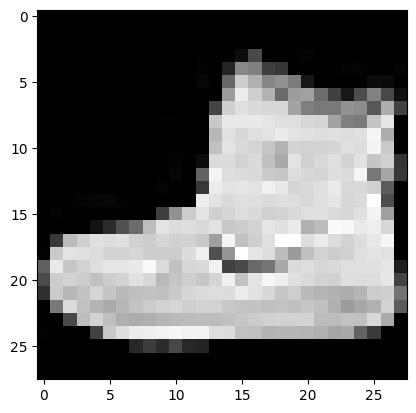

In [46]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0].reshape(28, 28), cmap='gray')

In [47]:
y_train[0]

9

In [48]:
x_train.shape


(60000, 784)

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1	Trouser
- 2	Pullover
- 3	Dress
- 4	Coat
- 5	Sandal
- 6	Shirt
- 7	Sneaker
- 8	Bag
- 9	Ankle boot

In [49]:
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_valid, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test= torch.tensor(y_valid, dtype=torch.long)

In [50]:
class MySimpleNN(torch.nn.Module):   # MySimpleNN erbt von torch.nn.Module

    # Konstruktor
    def __init__(self):
        # Aufruf des Superkonstruktors von torch.nn.Module
        super(MySimpleNN, self).__init__()
        # Definition der Schichten

        # fc1 --> fully connected layer 1 von 12 auf 70 Neuronen
        # warum 12? --> 12 Features
        self.fc1 = torch.nn.Linear(784, 300)
        # fc2 --> fully connected layer 2 von 70 auf 120 Neuronen
        self.fc2 = torch.nn.Linear(300, 100)
        # fc3 --> fully connected layer 3 von 120 auf 30 Neuronen
        self.fc3 = torch.nn.Linear(100, 10)
        # fc4 --> fully connected layer 4 von 30 auf 1 Neuronen
        # Warum 1 Neuron? --> 1 Output, wir lesen da den Alkoholgehahlt aus

        # Batch Normalization
        # 70, 120, 30 sind die Anzahl der Neuronen in den Schichten
        self.bn1 = torch.nn.BatchNorm1d(300)
        self.bn2 = torch.nn.BatchNorm1d(100)


    # forward Methode -> Forward Propagation
    # wenn ich später ein Objekt von MySimpleNN erzeuge, dann kann ich
    # dieses Objekt mit einem Tensor aufrufen, dann wird die forward Methode
    # aufgerufen. z.B. model(x_train)
    def forward(self, xb):   # xb steht für eine Batch von X-Werten
        #print("xb", xb.shape)
        z2 = self.fc1(xb)  # dahinter steckt x@w1 + b1
        a2 = torch.relu(z2)    # alle negativen Werte werden auf 0 gesetzt, der Rest bleibt
        #print("a2", a2.shape)
        a2_bn = self.bn1(a2) # Normalisierung der Werte auf den Neuronen
        #print("a2_bn", a2_bn.shape)
        z3 = self.fc2(a2_bn) # dahinter steckt a2@w2 + b2
        #print("z3", z3.shape)
        a3 = torch.relu(z3)
        #print("a3", a3.shape)
        a3_bn = self.bn2(a3)
        #print("a3_bn", a3_bn.shape)
        y_hat = self.fc3(a3_bn)

        return y_hat

In [51]:
def get_batch(x, y, batch_size):
    # z.B. range(0, 10, 3) --> 0, 3, 6, 9
    # range(start, stop, step)
    for i in range(0, len(x), batch_size):
        # yield: gibt den Wert zurück, aber merkt sich den aktuellen Zustand
        yield x[i:i+batch_size], y[i:i+batch_size]

In [52]:
model = MySimpleNN()
xb, yb = next(get_batch(x_train, y_train, 64))
model(xb).shape

torch.Size([64, 10])

Epoch:  0 Loss:  0.008636261540651322 LR:  0.0001
Epoch:  10 Loss:  0.0036771733591953915 LR:  0.0001
Epoch:  20 Loss:  0.0030420479784409207 LR:  0.0001
Epoch:  30 Loss:  0.0027091073403755824 LR:  0.0001
Epoch:  40 Loss:  0.002492352506518364 LR:  0.0001
Epoch:  50 Loss:  0.0023348269005616508 LR:  0.0001
Epoch:  60 Loss:  0.0022140419190128644 LR:  0.0001
Epoch:  70 Loss:  0.0021172076468666395 LR:  0.0001
Epoch:  80 Loss:  0.002037347505489985 LR:  0.0001
Epoch:  90 Loss:  0.001970512633025646 LR:  0.0001


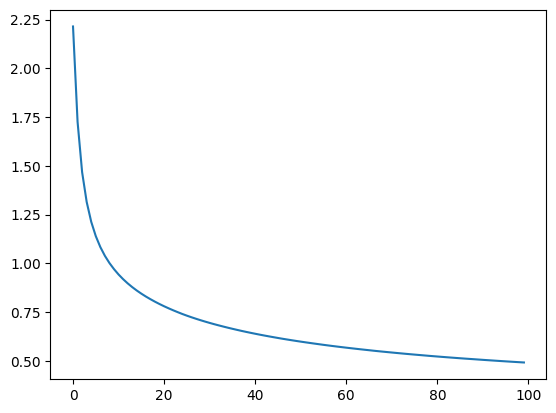

In [53]:
# eigenes Modell wird erstellt
model = MySimpleNN()
lr=0.0001
# trainiere immer mit 512 Datensätzen auf einmal
batch_size=256

# loss function
# Mean Squared Error
# die Lossfunction von Pytorch müssen erstmal erstellt werden mit ()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=10)

def train(xb, yb):
    y_hat=model(xb)
    loss = loss_fn(y_hat, yb)
    loss.backward()
    with torch.no_grad():
        # Iteration über alle Parameter im Modell
        for param in model.parameters():
            # Backpropagation, d.h. die Veränderung der Gewichte in Abhängigkeit der Ableitung
            param -= lr * param.grad
        # Alle Gradients im Modell werden auf 0 gesetzt
        model.zero_grad()
    return loss.item()

losses=[]
batch_count=len(x_train)//batch_size


for epoch in(range(100)):
    loss_sum=0
    # Iteration über alle Batches
    for xb, yb in get_batch(x_train, y_train, batch_size):
        loss_sum+=train(xb, yb)
    loss_epoch = loss_sum/len(x_train)
    losses.append(loss_sum/batch_count)
    scheduler.step(loss_epoch)
    if epoch % 10 == 0:
        print("Epoch: ", epoch, "Loss: ", loss_epoch, "LR: ", optimizer.param_groups[0]['lr'])

#plot
import matplotlib.pyplot as plt
plt.plot(losses)

In [54]:
xb_test, yb_test = next(get_batch(x_test, y_test, 64))
preds = model(xb_test)
preds.shape

torch.Size([64, 10])

In [55]:
torch.argmax(preds[0])

tensor(9)

In [56]:
yb_test[0]

tensor(9)

In [57]:
preds = model(x_test)
preds = torch.argmax(preds, dim=1)

In [58]:
correct=0
for i in range(len(preds)):
    if preds[i]==y_valid[i]:
        correct+=1

print(correct, "von ", len(x_valid), "korrekt vorhergesagt")

8313 von  10000 korrekt vorhergesagt
